# Photutils tutorial


## Morphological properties
Source: https://photutils.readthedocs.io/en/stable/morphology.html

## Elliptical Isophote Analysis
Source: https://photutils.readthedocs.io/en/stable/isophote.html

In [1]:
# import relevant packages
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import Gaussian2D
from astropy.stats import sigma_clipped_stats
from photutils.datasets import make_noise_image
from photutils.isophote import EllipseGeometry, Ellipse, build_ellipse_model
from photutils import EllipticalAperture, data_properties
from astropy.io import fits

In [2]:
#data = g(x, y) + noise
hdu=fits.open('/Users/lasilla/data/2020-02-10/reduced/NGC3311/NGC3311_R.fits')
data = hdu['PRIMARY'].data

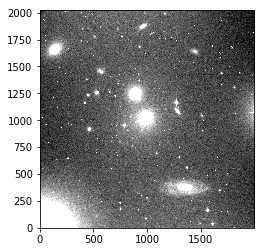

In [4]:
# how does it look?
plt.imshow(data, cmap='gray', origin='lower', vmin=25.6698, vmax=28.4909)

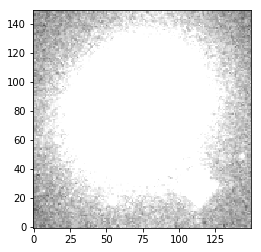

In [36]:
#cut
from astropy.nddata import Cutout2D
position = (885, 1240)
size=(150,150)
cutout=Cutout2D (data,position,size)
plt.imshow(cutout.data,cmap='gray', origin='lower', vmin=25.6698, vmax=28.4909)

We first need to estimate an initial guess of the ellipse geometry and pass it to the fitters.

In [37]:
# image statistics 
mean, median, std = sigma_clipped_stats(cutout.data, sigma=3.0)
# subract background
data_sub = cutout.data - median
# first guess
cat = data_properties(data_sub)
columns = ['id', 'xcentroid', 'ycentroid', 'semimajor_axis_sigma',
           'semiminor_axis_sigma', 'orientation']
tbl = cat.to_table(columns=columns)
# initialize an ellipse with the properties that we guessed
geometry = EllipseGeometry(x0=tbl['xcentroid'][0].value,
                           y0=tbl['ycentroid'][0].value,
                           pa=tbl['orientation'][0].value,
                           sma=tbl['semimajor_axis_sigma'][0].value,
                           eps=tbl['semiminor_axis_sigma'][0].value/tbl['semimajor_axis_sigma'][0].value
                           )

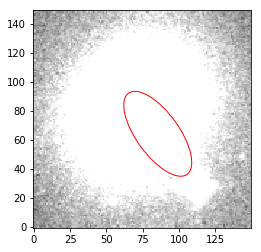

In [38]:
# how does it look?
plt.imshow(cutout.data, cmap='gray', origin='lower', vmin=25.6698, vmax=28.4909)
geometry.sma
aper = EllipticalAperture(positions=(geometry.x0, geometry.y0), 
                          a=geometry.sma,
                          b=geometry.sma*(geometry.eps),
                          theta=geometry.pa)
aper.plot(color='r')

Now we want to initiliaze an instance of the Ellipse class with the data and our initial guess and fit the data:

In [22]:
ellipse = Ellipse(data_sub, geometry)
isolist = ellipse.fit_image()

In [23]:
# save the output as a table
tab = isolist.to_table()
tab

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad_rerr,ndata,flag,niter,stop_code
,,,,,deg,deg,,,,,
float64,float64,float64,float64,float64,float64,float64,object,int64,int64,int64,int64
0.0,65.20262054024904,0.0,0.0,0.0,0.0,0.0,None,1,0,0,0
0.5277194311739052,64.48733395852749,0.05393570207602278,0.33245271370510954,0.028896824596157063,4.24058724845,3.19039777018,0.6550774095198343,13,0,10,0
0.5804913742912957,64.34713991937163,0.057847626731775556,0.3179117262073615,0.02834786278960882,5.66296943901,3.24361418115,0.6321922677846346,13,0,10,0
0.6385405117204254,64.17498591437091,0.06202936091931455,0.28693583424714564,0.02290290614367913,7.50538523398,2.85061456535,0.46078449815252015,13,0,10,0
0.7023945628924679,63.788061775924724,0.062007964198664375,0.15001735399769428,0.01915023315563423,14.9220407908,4.22182639663,0.33082835584330467,13,0,10,0
0.7726340191817147,63.47486397316967,0.0714616414784472,0.10234851267412065,0.01969473275532484,42.6760321015,6.20423502061,0.3118241785169815,13,0,10,0
0.8498974210998862,63.15249413434764,0.07471410066667725,0.10234851267412065,0.015563553689381915,65.6010756278,4.90298093642,0.2219251983963679,13,0,10,0
0.9348871632098749,62.76802531155196,0.06878014687063626,0.1268868701561539,0.01259470224471179,67.3113569132,3.24199198776,0.19839567313813508,13,0,10,0


<ErrorbarContainer object of 3 artists>

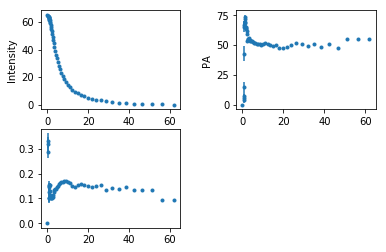

In [26]:
# have a look at some of the fitted parameters:
fig = plt.figure()
ax1 = fig.add_subplot(221)
fig.subplots_adjust(wspace=0.4)
ax1.errorbar(tab['sma'], tab['intens'],
             yerr=tab['intens_err'],
             fmt='.')
ax1.set_ylabel('Intensity')
ax2 = fig.add_subplot(222, sharex=ax1)
ax2.errorbar(tab['sma'], tab['pa'].value,
             yerr=tab['pa_err'].value,
             fmt='.')
ax2.set_ylabel('PA')
ax3 = fig.add_subplot(223, sharex=ax1)
ax3.errorbar(tab['sma'], tab['ellipticity'],
             yerr=tab['ellipticity_err'],
             fmt='.')
#ax3.set_ylabel('Ellipticity')
 #ax4 = fig.add_subplot(224, sharex=ax1)
 #ax4.errorbar(tab['sma'], tab['x0'],
                  #yerr=tab['x0_err'],
                  #fmt='.')
 #ax4.set_ylabel('x0')

We can also build a model image from the fit that we just calculated and deterime the residuals of the fit:

In [ ]:
model_image = build_ellipse_model(cutout.data.shape, isolist)
residual = cutout.data - model_image

In [ ]:
fig = plt.figure()
fig.subplots_adjust(wspace=0.5)
ax1 = fig.add_subplot(131)
ax1.imshow(cutout.data, cmap='gray', origin='lower')
ax1.set_title('Data')
ax2 = fig.add_subplot(132)
ax2.imshow(model_image, cmap='gray', origin='lower')
ax2.set_title('Model')
ax3 = fig.add_subplot(133)
ax3.imshow(residual, cmap='gray', origin='lower')
ax3.set_title('Residual')